In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

from pymultifracs.robust.benchmark import gen_estimate
from pymultifracs.simul.noisy import generate_simuls_bb, gen_noisy

In [3]:
N = 2 ** 18

In [27]:
noisy_X = gen_noisy(*generate_simuls_bb(N, lambd=np.sqrt(.05)), coverage=[3],
                    SNR=np.array([.25]), align_scale=12).squeeze()

In [28]:
from pymultifracs import wavelet_analysis
from pymultifracs.robust.robust import get_outliers

In [29]:
WT = wavelet_analysis(noisy_X).integrate(gamint=1)

In [30]:
from pymultifracs import mfa

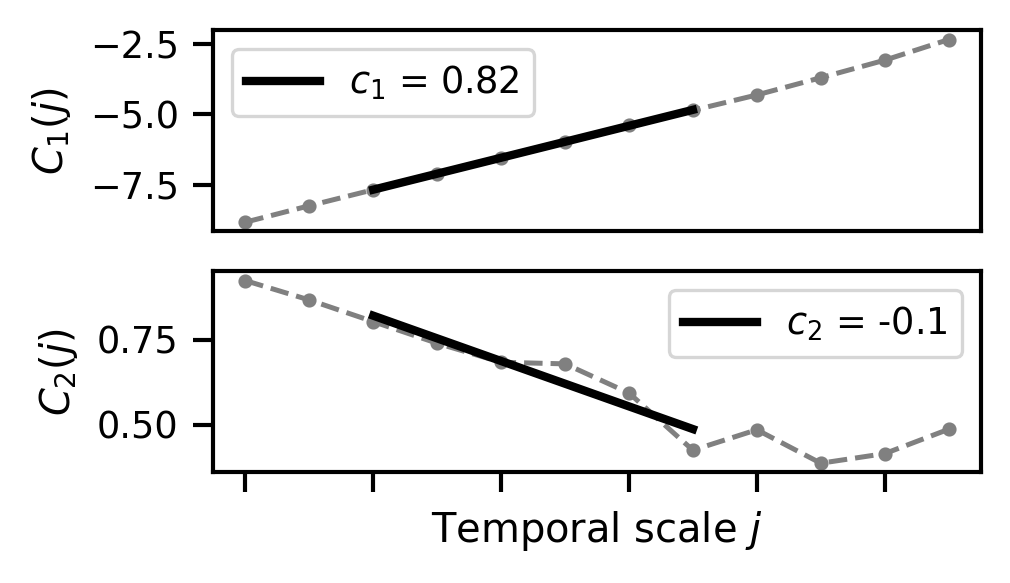

w=array([1., 1., 1., 1., 1., 1.])


<Figure size 1920x1440 with 0 Axes>

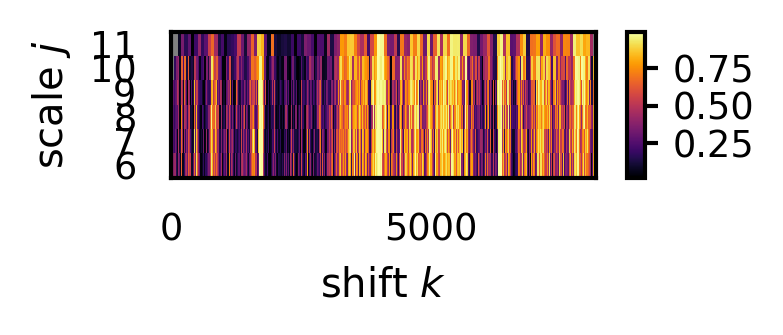

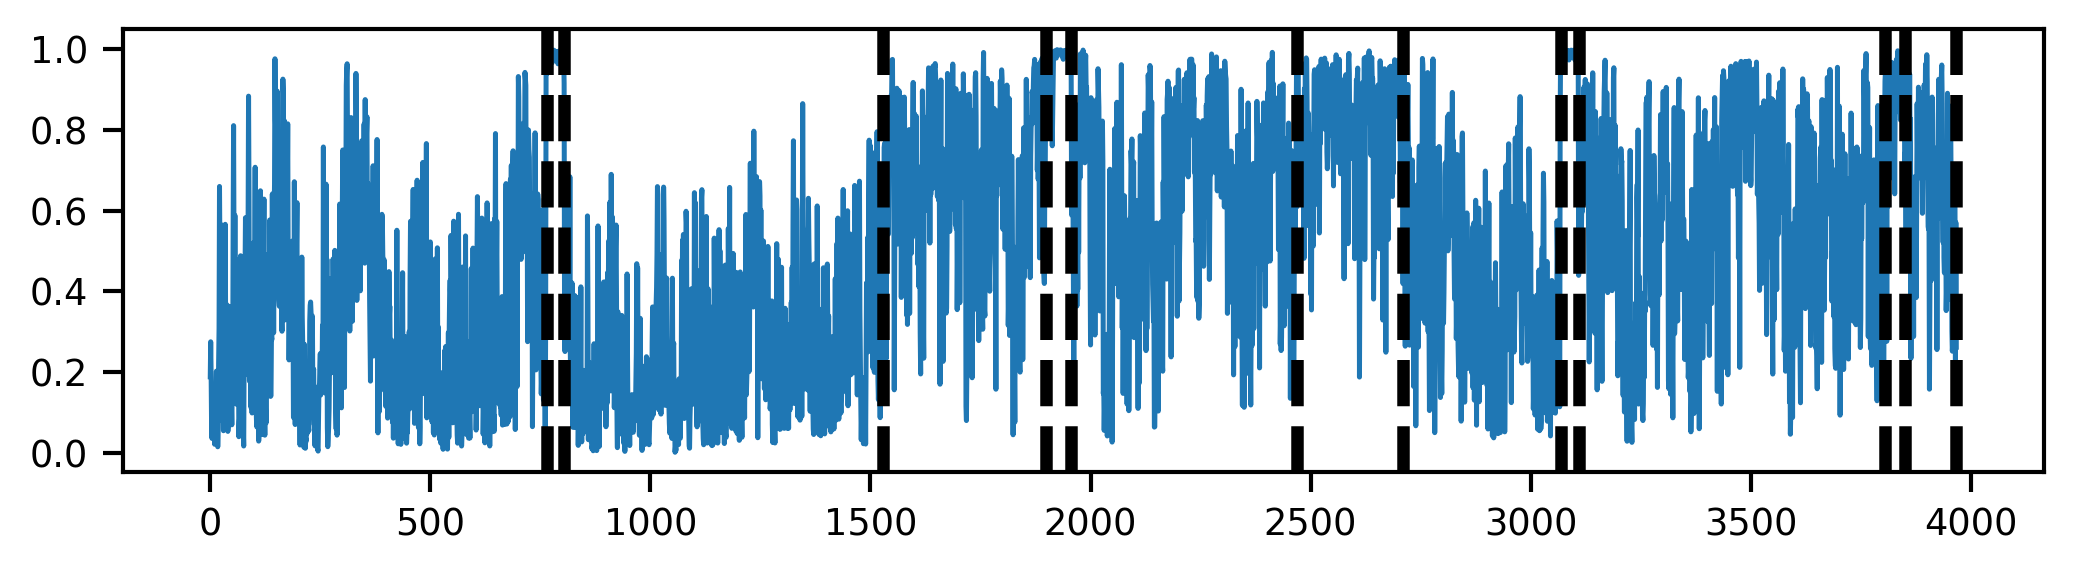

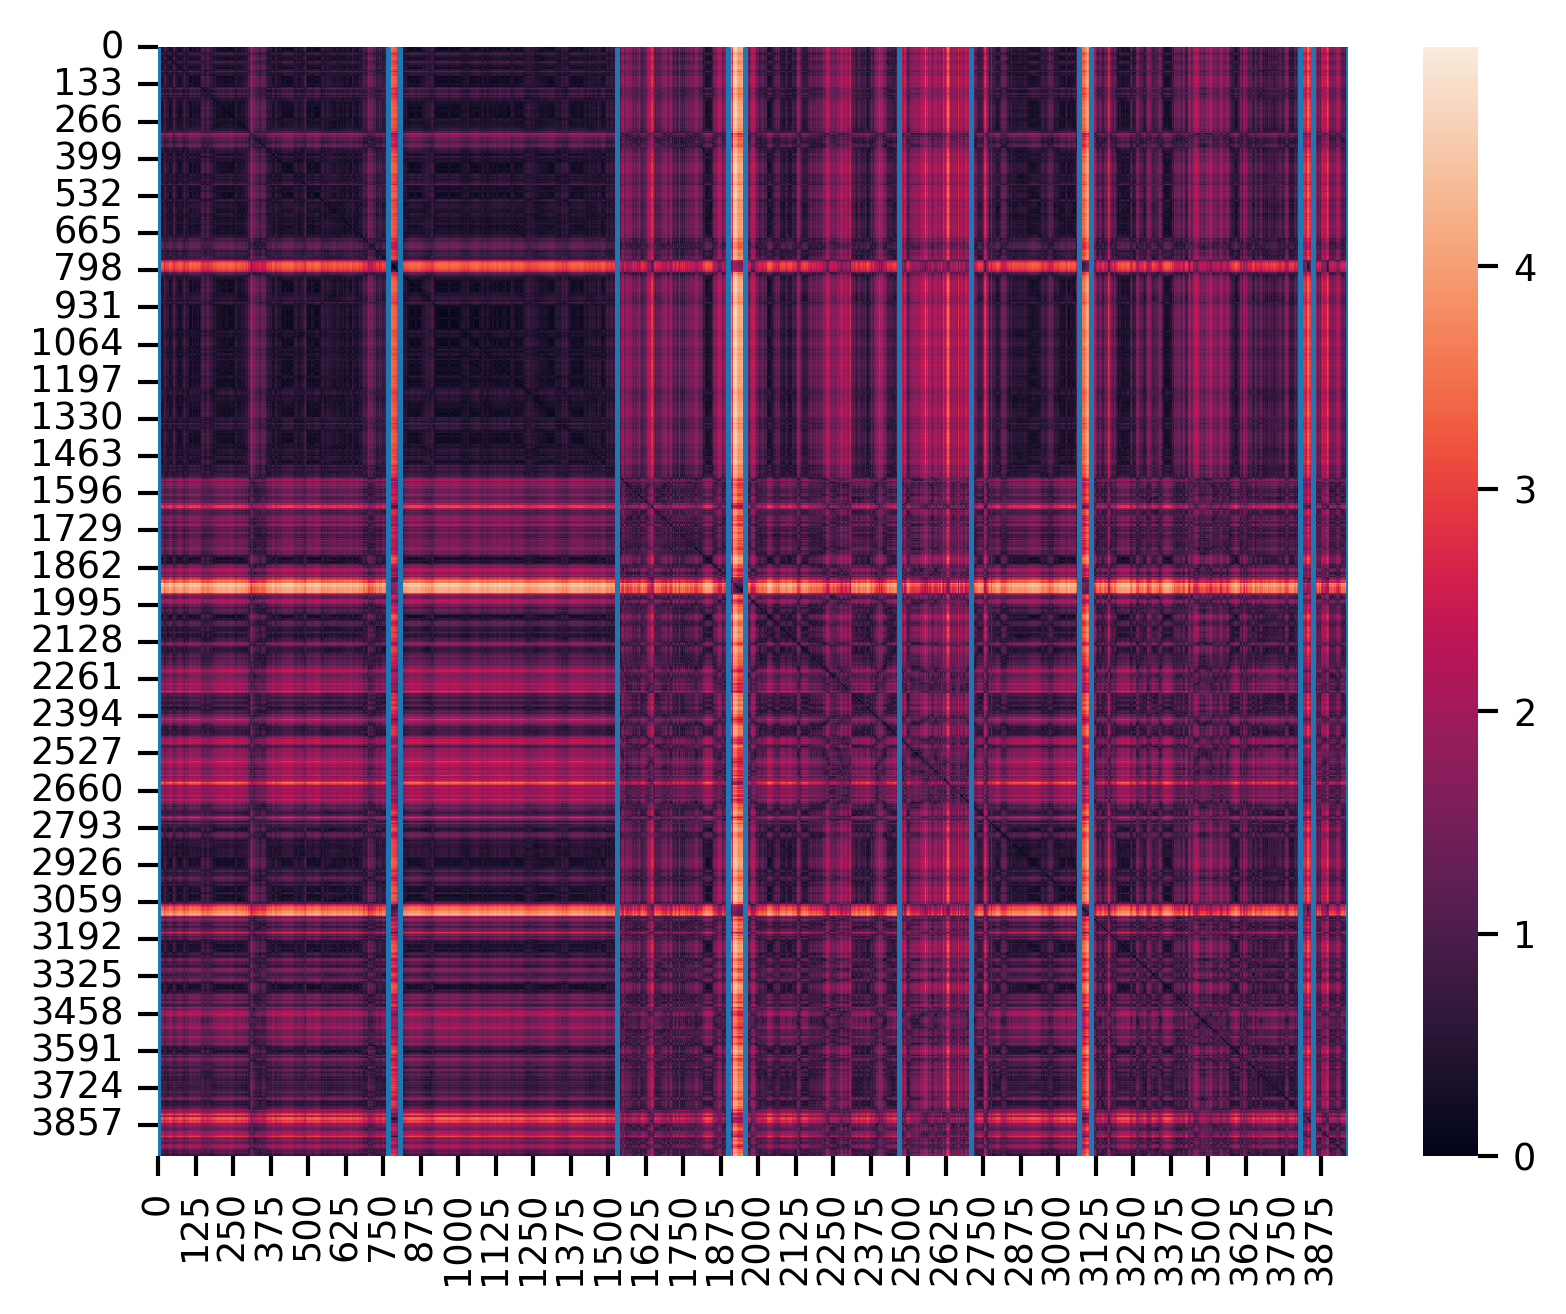

[0.654975319859233, 3.463153302087852, 0.835978476512944, 0.43923336950971426, 3.476936735402724, 0.329641457868356, 0.9997194065166131, 0.3680910866456585, 3.6769464101727203, 0.27235084116040775, 1.3977233603928676, 0.3825112359782794]
[0.6082178488919863, 3.190523343972816, 0.8100089714923497, 0.4247806205523163, 3.028779009387186, 0.2929098048966752, 0.9614046963737755, 0.3477049720200596, 2.927129335134103, 0.25926754803950464, 1.6370682802662633, 0.4421590987022699]
[0.6230745833533742, 2.888740650415861, 0.8229102813808906, 0.43868134774421563, 2.928869255298987, 0.3263504068740431, 1.0291053987164176, 0.323510350017139, 2.6921411979917123, 0.2868941531688606, 1.6567403763104671, 0.49537487184806184]
[0.6710974120967269, 2.7264811998990215, 0.8775845921447194, 0.4356366204290357, 3.0718144766155246, 0.3133732840564203, 1.086245176349083, 0.3760055064647362, 3.1188810929706605, 0.28902881946515024, 2.0575618265832527, 0.6557465179488093]
[0.6384249120373073, 1.6450196742637535, 0

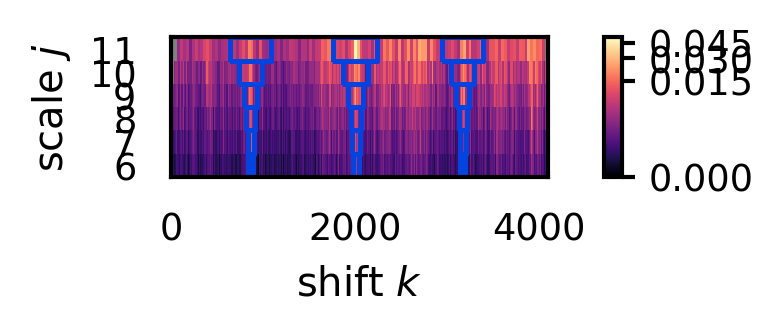

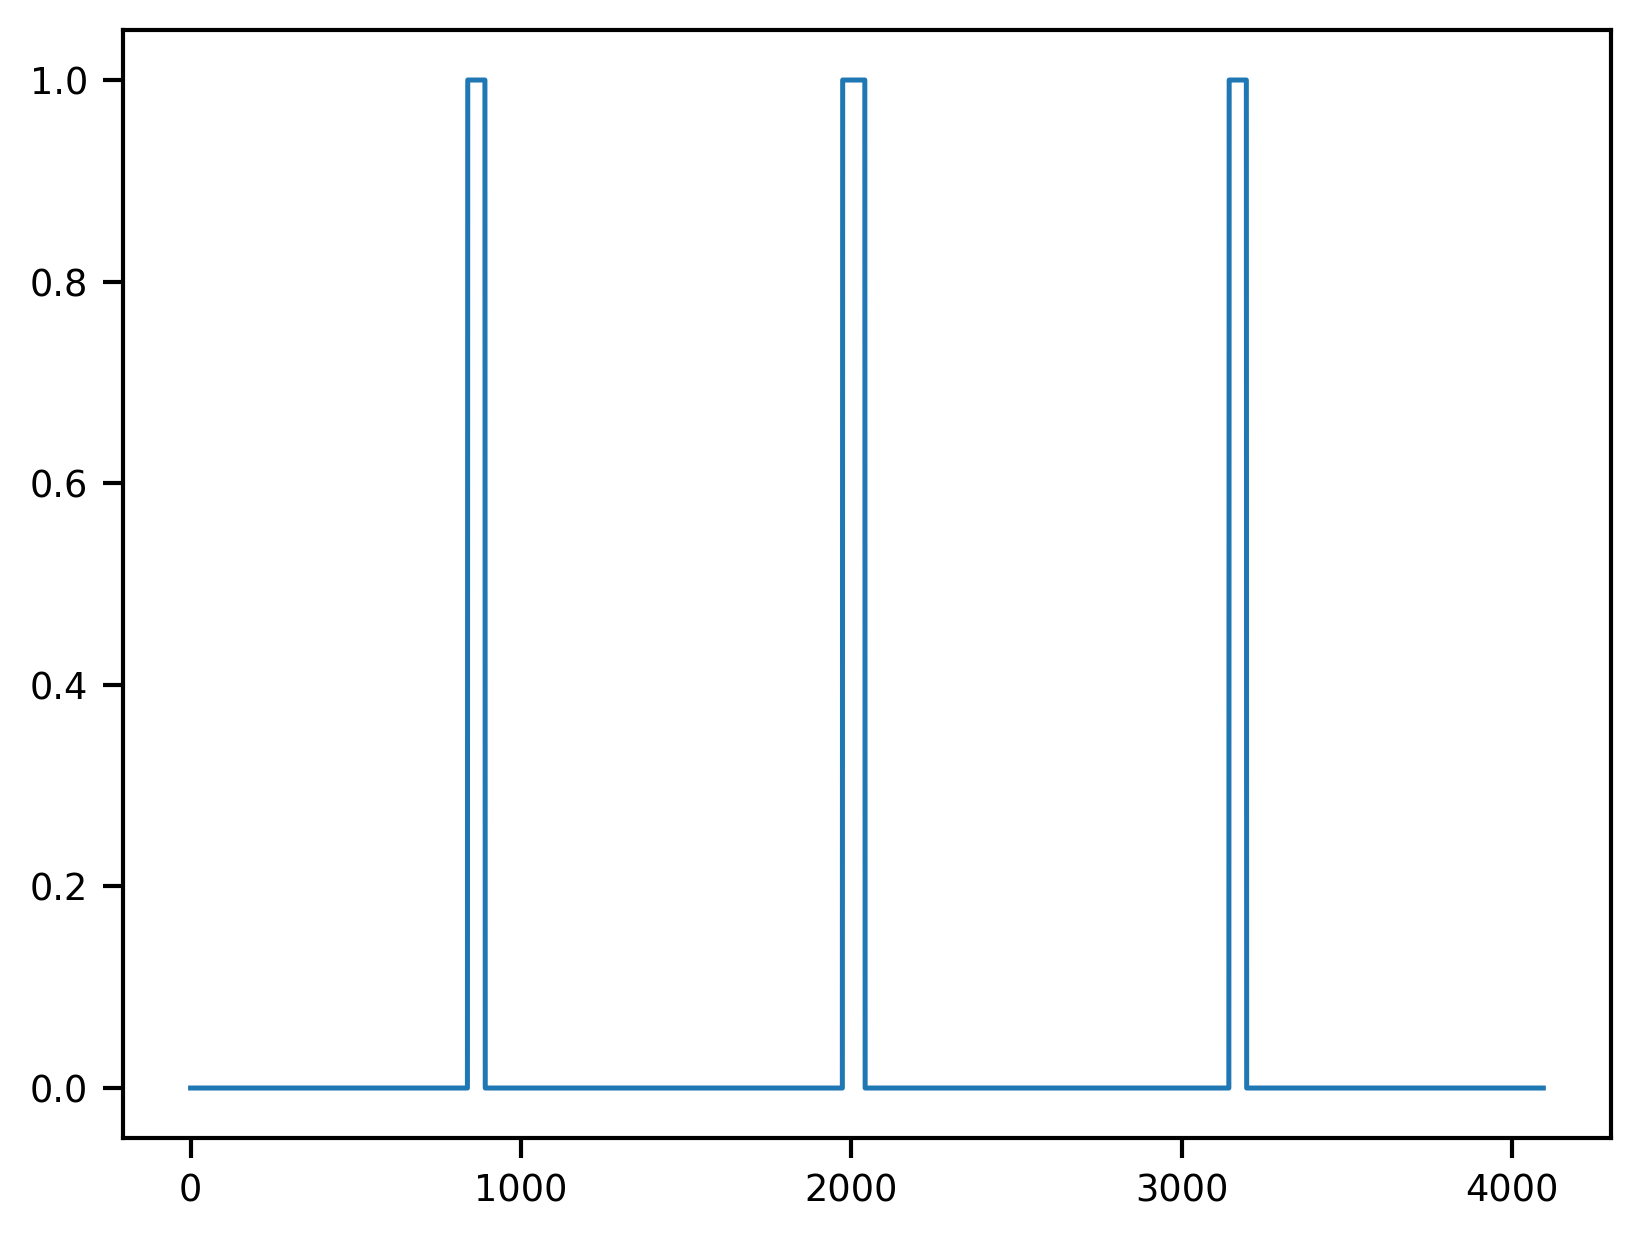

In [34]:
_, idx_reject= get_outliers(
    WT, [(6, 11)], verbose=True, generalized=False, pelt_beta=50, pelt_jump=5,
    threshold=3)

In [35]:
lwt = mfa(WT.get_leaders(2), [(6, 11)], idx_reject=idx_reject)

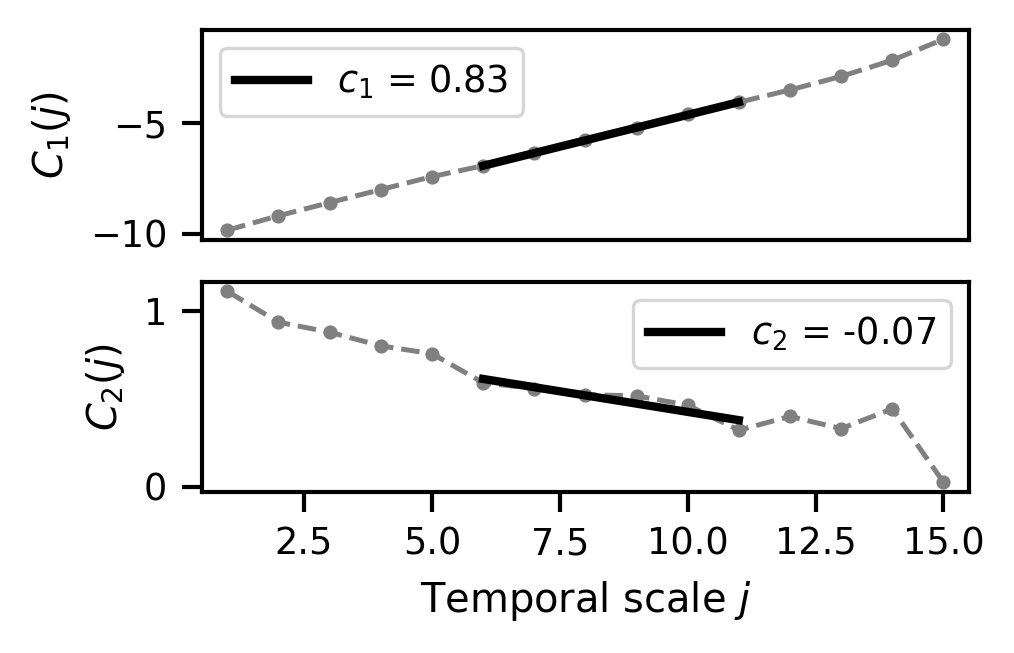

In [36]:
lwt.cumulants.plot()

In [37]:
SNRgrid = np.r_[0, np.geomspace(.125, 8, 7)]
covgrid = np.array([3])

In [12]:
df_naive = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
                        n_jobs=8, align_scale=12, lambd=np.sqrt(.05))

  0%|          | 0/40 [00:00<?, ?it/s]

In [13]:
df_cm = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
                     n_jobs=8, align_scale=12, robust_cm=True,
                     lambd=np.sqrt(.05))

  0%|          | 0/40 [00:00<?, ?it/s]

In [38]:
df_leader_gen = gen_estimate(
    N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40, n_jobs=8,
    align_scale=12, outlier_detect=True, lambd=np.sqrt(.05), robust_cm=False,
    generalized=True,
    robust_kwargs=dict(pelt_jump=5, pelt_beta=50, threshold=3)
)

  0%|          | 0/40 [00:00<?, ?it/s]

In [39]:
import pandas as pd

In [40]:
df_plot2 = pd.concat([df_naive.stack().loc[:, :, 3],
                      df_cm.stack().loc[:, :, 3],
                       #  df_coef2.stack().loc[:, :, 3],
                       #  df_leader2.stack().loc[:, :, 3],
                      df_leader_gen.stack().loc[:, :, 3],
                     ],
                     keys=['Naive', 'Robust cumulants', 'Log-exp. power'], names=['method', 'rep', 'SNR'])

/tmp/ipykernel_8467/887793517.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_plot2 = pd.concat([df_naive.stack().loc[:, :, 3],
/tmp/ipykernel_8467/887793517.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cm.stack().loc[:, :, 3],
/tmp/ipykernel_8467/887793517.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_leader_gen.stack().loc[:, :, 3],


In [41]:
df_melt2 = df_plot2.reset_index().melt(['method', 'rep', 'SNR'])
df_melt2 = df_melt2.query('cumulant in ["c1", "c2"]')

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
col_width = 3.346

In [43]:
mpl.rcParams['figure.dpi'] = 300
sns.set_context('paper')

In [44]:
df_leader_gen.groupby('SNR').mean()

cumulant,c1,c2
coverage,3,3
SNR,,
0.000,0.824813,-0.052444
0.125,0.819515,-0.066170
0.250,0.830270,-0.053478
0.500,0.831348,-0.052663
1.000,0.832530,-0.051756
2.000,0.832464,-0.051779
4.000,0.832660,-0.051694
8.000,0.832887,-0.051584


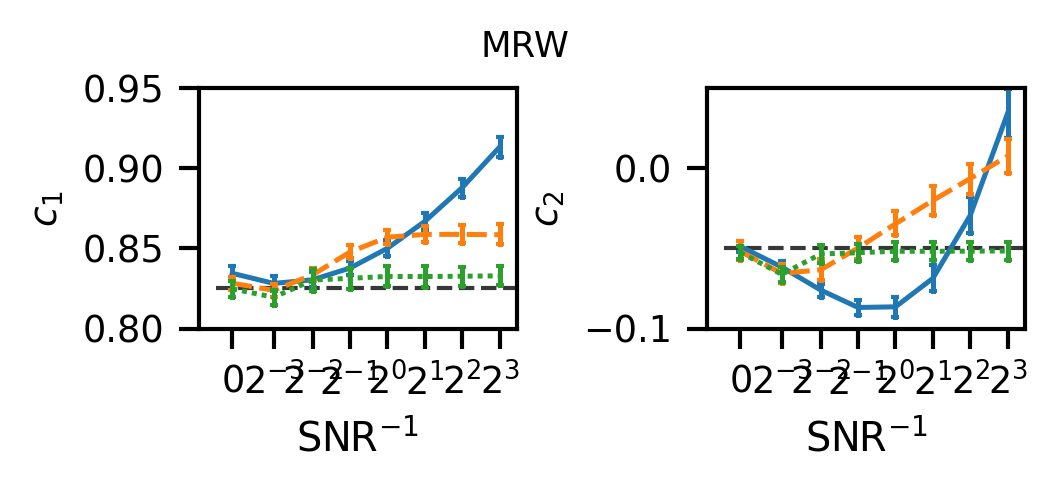

In [45]:
h = 1.7
fg = sns.relplot(df_melt2, x='SNR', kind='line', y='value', col='cumulant',
                 facet_kws={'sharey': False, 'despine':False, 'legend_out': False},
                 hue='method', height=h, aspect=col_width / 1.85 / h, legend=False,
                 style='method', errorbar='ci', err_style='bars', err_kws={'capsize':1}
                 )
plt.xscale('symlog', base=2, linthresh=.225)
fg.axes[0, 0].hlines(.8 + .05 / 2, -.05, 2 ** 3 + 3, ls='--', color='xkcd:dark grey', zorder=1, lw=1)
# c1_0 = df_melt2.query('SNR == 0').query('cumulant == "c1"').query('method == "Naive"').value.mean()
# fg.axes[0, 0].hlines(c1_0, -.05, 2 ** 3 + 3, ls='--', color='xkcd:dark blue', zorder=1, lw=1)
fg.axes[0, 0].set(xlim=(-.1, 2 ** 3 + 3), ylim=(.8, .95))
fg.axes[0, 0].set(ylabel='$c_1$', xlabel='$\mathrm{SNR}^{-1}$', title='')
fg.axes[0, 0].yaxis.label.set_size(9)

fg.axes[0, 1].hlines(-.05, -.05, 2 ** 3 + 3, ls='--', color='xkcd:dark grey', zorder=1, lw=1)
fg.axes[0, 1].set(ylabel='$c_2$', xlabel='$\mathrm{SNR}^{-1}$', title='', ylim=(-.1, .05))
fg.axes[0, 1].yaxis.label.set_size(9)

leg = fg._legend

plt.suptitle('MRW', size=8.5, y=.92)
# plt.suptitle('MRW, $H=0.8$, $\lambda=\sqrt{0.05}$', size=8.5)

if leg is not None:
    # # leg.draw_frame(False)
    leg.set_title('')
    for t in leg.texts:
    #     t.set_text(rf"$\tau_D={float(t.get_text()):0.0f}$")
        t.set_size(7)
    # sns.move_legend(g.axes[0, 0], 'upper left', ncols=1)

# fg.axes[0, 0].annotate('(c)', (0, 1), xycoords='axes fraction', size=7,
#                   va='top', xytext=(4, -4), textcoords='offset points', color='.1')
# fg.axes[0, 1].annotate('(d)', (0, 1), xycoords='axes fraction', size=7,
#                   va='top', xytext=(4, -4), textcoords='offset points', color='.1')

# add_letter(fg.axes[0, 0], 'B', offset_x=0, offset_y=-11.5)

# plt.savefig(figures_folder / 'MRW.pdf', bbox_inches='tight')